In [1]:
# import modules for Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer, IBMQ, execute, schedule
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

import numpy as np
from numpy import pi
np.set_printoptions(precision=3)

import pandas as pd
import sys, hashlib, os, random, time, math
from datetime import date

if sys.version_info < (3, 6):
	import sha3

# code for getting the backend
print("Getting provider...")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# choose the hardware
backend = provider.get_backend('ibm_nairobi')
simulator_name = 'qasm_simulator'

# parameters
numberOfcalcs = 5
MAX_NONCE = 2**32
previous_hash = '' # empty hash
block_number = 0
transactions ='Schroedinger paid Einstein 1 qBTC'
n_qreg_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] # list of the numbers of qubits to experiment with
qubit_arr = [0, 1, 3, 5, 4]
num_intersection = 100 # don't change this - how many different numbers of intersection to keep track of
error_list = [None]*len(n_qreg_list) # list of errors for each number of qubits

# create data files
today = date.today().strftime("%Y%m%d")
filepath = os.path.join(os.getcwd(), 'Results_'+today) #specify data storage folder
filename_log = os.path.join(filepath, today + f'_results_{n_qreg_list[0]}qubits.txt')

# QPoW cycle: function takes the input text (block number, nonce,...) and pushes it through once 

def qPoW(text, quantum_circuit, errors, num_states, num_intersection):
    """
    qPoW takes the input text and pushes it through once, and it updates the array of errors

    :param text: the text that is hashed and used to parameterize the quantum circuit
    :param quantum_circuit: the function to build the parameterized quantum circuit
    :param errors: the array of errors for different percentages of maxstates and overlap requirements
    :param num_states: the maximum number of states considered
    :param num_intersection: the number of overlap percentages considered (from 0% to 100%)
    :return: the updated error array
    """
    hashIn = hashlib.sha3_256(text.encode("ascii")).hexdigest() # hashing the 'text' input
    str1 = 'hashIn-hex: ' + str(hashIn) + ' length ' + str(len(hashIn))
    print(str1, '\n')

    # convert hashIn(hex) to hashIn_bin(binary)
    scale = 16 # hex base
    hashIn_bin = bin(int(hashIn, scale))[2:].zfill(len(hashIn)*4)
    str2 = 'hashIn-binary: ' + str(hashIn_bin) + ' length ' + str(len(hashIn_bin))
    print(str2, '\n')

    # comparison of the results produced by quantum simulator and quantum computer
    qstate_bin_sim, sim_time = sim_quantum_operation(quantum_circuit_verification, hashIn_bin, num_states)
    qstate_bin_exp, exp_time = exp_quantum_operation(quantum_circuit, hashIn_bin, num_states) #qstate is a 256 binary number

    # error rate calculation
    for states in range(1, num_states+1):
        maxstates_sim = set(qstate_bin_sim[:states])
        maxstates_exp = set(qstate_bin_exp[:states])
        overlap_val = math.ceil(overlap(maxstates_sim, maxstates_exp)*num_intersection/states+1e-20)
        errors[states][overlap_val:num_intersection+1]+=1
    return errors, str1, str2, sim_time, exp_time

def overlap(maxstates_sim, maxstates_exp):
    """
    overlap calculates the overlap between two sets

    :param maxstates_sim: the set of states from the simulation
    :param maxstates_exp: the set of states from the noise simulator or quantum computer
    :return: the number of overlapping states
    """
    return len(maxstates_sim.intersection(maxstates_exp))
    
# converting hashIn_bin to a bit string to pass thru a quantum processor
def break_up_4bit_values(hashIn_bin):
    """
    break_up_4bit_values converts the input into an array of 4-bit strings

    :param hashIn_bin: the binary string that is broken up
    :return: array of 4-bit strings
    """
    array_4_bit_values = []

    for i in range(64): 
      four_bits = hashIn_bin[2+4*i:2+4*i+4]
      array_4_bit_values.append(four_bits)
        
    print("hashIn binary split into 4bit bins:", array_4_bit_values)
    return array_4_bit_values

def quantum_circuit(q_par, n_qreg, circ_layer = 1):
    """
    quantum_circuit builds a paramterized quantum circuit

    :param q_par: the parameters
    :param n_qreg: the number of qubits
    :param circ_layer: the number of times to repeat the circuit
    :return: the quantum circuit
    """
    k = 0 # counter for the parameter values
    
    # circuit 15
    # setting the quantum circuit:
    n = backend.configuration().n_qubits
    qreg_q = QuantumRegister(n, 'q')
    creg_c = ClassicalRegister(n, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    for layer in range(circ_layer):

        for i in range(n_qreg):   
            circuit.ry(pi/2, qreg_q[qubit_arr[i]])

        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[qubit_arr[n_qreg-i-1]], qreg_q[qubit_arr[(n_qreg-i)%n_qreg]])
        k+=n_qreg
        
        for i in range(n_qreg):
            circuit.ry(pi/2, qreg_q[qubit_arr[i]])
        
        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[qubit_arr[i]], qreg_q[qubit_arr[i-1]])
        k+=n_qreg

    # measurements of all qubits
    for i in range(n_qreg):
        circuit.measure(qreg_q[qubit_arr[i]], creg_c[i])

    return circuit

def quantum_circuit_verification(q_par, n_qreg, circ_layer = 1):
    """
    quantum_circuit_verification builds a paramterized quantum circuit for verification

    :param q_par: the parameters
    :param n_qreg: the number of qubits
    :param circ_layer: the number of times to repeat the circuit
    :return: the quantum circuit
    """
    k = 0 # counter for the parameter values
    
    # circuit 15
    # setting the quantum circuit:
    n = min(24, n_qreg)
    qreg_q = QuantumRegister(n, 'q')
    creg_c = ClassicalRegister(n, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    for layer in range(circ_layer):

        for i in range(n_qreg):   
            circuit.ry(pi/2, qreg_q[i])

        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[n_qreg-i-1], qreg_q[(n_qreg-i)%n_qreg])
        k+=n_qreg
        
        for i in range(n_qreg):
            circuit.ry(pi/2, qreg_q[i])
        
        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[i], qreg_q[i-1])
        k+=n_qreg

    # measurements of all qubits
    for i in range(n_qreg):
        circuit.measure(qreg_q[i], creg_c[i])

    return circuit


def exp_quantum_operation(quantum_circuit, hashIn, num_states):
    """
    exp_quantum_operation runs the paramterized circuit with either a noise simulator or a real quantum computer

    :param quantum_circuit: function that returns the desired quantum circuit
    :param hashIn: the SHA3-256 hash of the input string
    :param num_states: the maximum number of states considered
    :return: the top num_states output states in an array
    """
    # input hashIn string
    fourbit_array = break_up_4bit_values(hashIn)
    q_par = [int(fourbit_array[i],2) for i in range(len(fourbit_array)-1)] #throwing away the last string element
    circuit = quantum_circuit(q_par, n_qreg)
    
    transpiled_circuit = transpile(circuit, backend, seed_transpiler=13)
    qpu_job = backend.run(transpiled_circuit, shots=20000)
    job_id = qpu_job.job_id()
    job_monitor(qpu_job)
    results = qpu_job.result()
    print("Quantum computation time taken: " + str(results.time_taken) + '\n')

    counts = results.get_counts(circuit)

    # picking up the maximally probable states
    max_state256 = sorted(counts, key=counts.get, reverse=True)[:num_states]
    
    #draw the quantum circuit
    drawC_filename = os.path.join(filepath, '_exp_circuit_' + job_id)
    drawTC_filename = os.path.join(filepath, '_exp_transpiled_circuit_' + job_id)
    circuit.draw('mpl', fold=0, filename = drawC_filename)
    
    return max_state256, results.time_taken # 4bit vector

# quantum simulator run
def sim_quantum_operation(quantum_circuit, hashIn, num_states):
    """
    sim_quantum_operation runs the paramterized circuit with the qasm simulator

    :param quantum_circuit: function that returns the desired quantum circuit
    :param hashIn: the SHA3-256 hash of the input string
    :param num_states: the maximum number of states considered
    :return: the top num_states output states in an array
    """
    # input hashIn string
    fourbit_array = break_up_4bit_values(hashIn)
    q_par = [int(fourbit_array[i],2) for i in range(len(fourbit_array)-1)] #throwing away the last string element
    circuit = quantum_circuit(q_par, n_qreg)

    backend = BasicAer.get_backend(simulator_name) # run on local simulator by default 

    job = execute(circuit, backend, shots=20000)

    # Monitor job progress and wait until complete:
    job_monitor(job)

    # Get the job results (this method also waits for the job to complete):
    results = job.result()
    print("Verification time taken: " + str(results.time_taken) + '\n')
    
    counts = results.get_counts(circuit)

    # picking up the maximally probable states
    max_state256 = sorted(counts, key=counts.get, reverse=True)[:num_states]
    
    #draw the quantum circuit
    drawC_filename = os.path.join(filepath, '_sim_circuit' + str(nonce))
    circuit.draw('mpl', fold=0, filename = drawC_filename)

    return max_state256, results.time_taken # 4bit vector

# main method
if(not os.path.isdir(filepath)):
    os.mkdir(filepath)
sim_time_arr = []
exp_time_arr = []

for i in range(len(n_qreg_list)):
    n_qreg = n_qreg_list[i]

    num_states = int(.01*2**n_qreg)
 
    # Execute both exp and qPoW
    nonce = random.randint(0, MAX_NONCE)
    text = str(block_number) + transactions + previous_hash + str(nonce) #hash input
    hashIn = hashlib.sha3_256(text.encode("ascii")).hexdigest() # hashing the 'text' input
    hash_hex = 'hashIn-hex: ' + str(hashIn) + ' length ' + str(len(hashIn))
    scale = 16 # hex base
    hashIn_bin = bin(int(hashIn, scale))[2:].zfill(len(hashIn)*4)
    hash_binary = 'hashIn-binary: ' + str(hashIn_bin) + ' length ' + str(len(hashIn_bin))

    # comparison of the results produced by quantum simulator and quantum computer
    qstate_bin_sim, sim_time = sim_quantum_operation(quantum_circuit_verification, hashIn_bin, num_states)
    sim_time_arr.append(sim_time)
    if(n_qreg <= len(qubit_arr)):
        qstate_bin_exp, exp_time = exp_quantum_operation(quantum_circuit, hashIn_bin, num_states) #qstate is a 256 binary number
        exp_time_arr.append(exp_time)
    with open(filename_log, 'a') as o:
        o.write(f'Verification time taken: {sim_time}' + '\n')
        if(n_qreg <= len(qubit_arr)):
            o.write(f'Quantum computation time taken: {exp_time}' + '\n')
        o.write('nonce: ' + str(nonce) + '\n')
        o.write('text: ' + text + '\n')
        o.write(hash_hex + '\n')
        o.write(hash_binary + '\n')
        o.write('\n')

Getting provider...
hashIn binary split into 4bit bins: ['1001', '0111', '0010', '1011', '1110', '0010', '1101', '1011', '0100', '0001', '1010', '0110', '1111', '0110', '1001', '0000', '0011', '1101', '0110', '0001', '1000', '1010', '0101', '0101', '0010', '1111', '0110', '1101', '0101', '1110', '0000', '0010', '0110', '0101', '1001', '1111', '0001', '1110', '1110', '1100', '0101', '0001', '0000', '0011', '1110', '1110', '0100', '1101', '1000', '1010', '0101', '1101', '1101', '0010', '0001', '0100', '0101', '1111', '0110', '0110', '0111', '1101', '0000', '10']
Job Status: job has successfully run
Verification time taken: 0.02625560760498047

hashIn binary split into 4bit bins: ['1001', '0111', '0010', '1011', '1110', '0010', '1101', '1011', '0100', '0001', '1010', '0110', '1111', '0110', '1001', '0000', '0011', '1101', '0110', '0001', '1000', '1010', '0101', '0101', '0010', '1111', '0110', '1101', '0101', '1110', '0000', '0010', '0110', '0101', '1001', '1111', '0001', '1110', '1110', '

In [2]:
print(sim_time_arr)
print(exp_time_arr)

[0.02625560760498047, 0.03300762176513672, 0.04400992393493652, 0.054012298583984375, 0.06006336212158203, 0.07001638412475586, 0.08252286911010742, 0.08802151679992676, 0.10652947425842285, 0.11152768135070801, 0.12053442001342773, 0.1365358829498291, 0.1565406322479248, 0.18854904174804688, 0.2710154056549072, 0.40496110916137695, 0.6972858905792236, 1.1138169765472412, 2.611264944076538, 4.888233184814453, 9.791503190994263, 20.271171808242798, 41.82128620147705]
[15.759706258773804, 18.18604278564453, 17.90552544593811, 47.550134897232056]


In [3]:
# sim_time_arr = [0.02600550651550293, 0.033008575439453125, 0.04401040077209473, 0.05312943458557129, 0.06351876258850098, 0.07152032852172852, 0.08001828193664551, 0.09052419662475586, 0.09952855110168457, 0.11440610885620117, 0.12353372573852539, 0.1365361213684082, 0.16004538536071777, 0.1930532455444336, 0.2785806655883789, 0.39810872077941895, 0.7116992473602295, 1.1451234817504883, 2.5177388191223145, 5.2239766120910645, 10.61961054801941, 21.764851808547974, 44.398592710494995]
# exp_time_arr = [10.999340534210205, 11.565367460250854, 10.149549007415771, 10.36188793182373]

In [4]:
import csv
with open(filepath + '\\sim_time_arr.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(sim_time_arr)

In [5]:
#fitting functions
sim_time_fit = [1.75*1e-6*np.exp(0.71*n_qreg_list[i]) for i in range(len(n_qreg_list))]
exp_time_fit = [sum(exp_time_arr)/len(exp_time_arr) for i in range(len(n_qreg_list))]

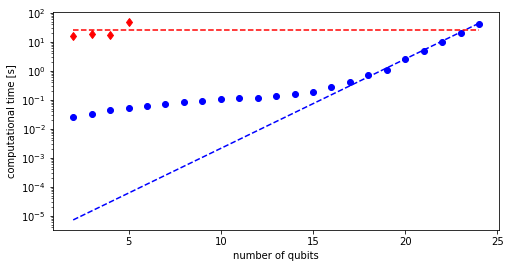

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 4))
plt.yscale('log')
plt.xlabel('number of qubits')
plt.ylabel('computational time [s]')
sim_locations = np.arange(2,25,1)
exp_locations = np.arange(2,1+len(qubit_arr),1)
plt.plot(sim_locations, sim_time_arr, 'bo')
plt.plot(sim_locations, sim_time_fit, 'b--')
plt.plot(exp_locations, exp_time_arr, 'rd')
plt.plot(sim_locations, exp_time_fit, 'r--')
plt.savefig('quantum_advantage.png')
plt.show()

In [10]:
accuracy_arr = []
CNOT_error = 0.597e-3 #peekskill median CNOT error
readout_error = 1.17e-2 #peekskill median readout error
for i in range(2, 25):
    accuracy_arr.append((1-CNOT_error)**(2*i-2)*(1-readout_error)**i)
speedup_arr = []
for i in range(0, len(qubit_arr)-1):
    speedup_arr.append(sim_time_fit[i]/exp_time_fit[i])
advantage_arr = []
for i in range(0, len(qubit_arr)-1):
    advantage_arr.append(accuracy_arr[i]*speedup_arr[i])

No handles with labels found to put in legend.


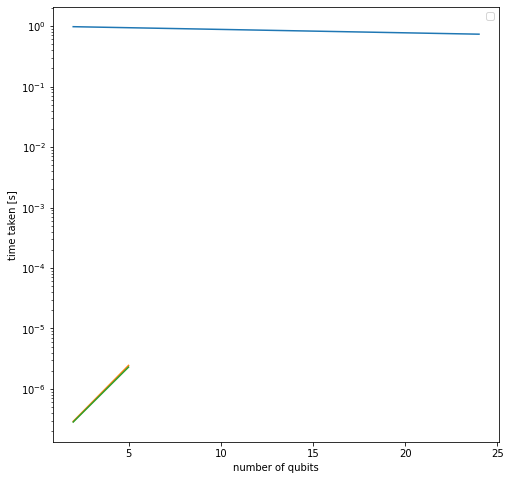

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 8))
plt.yscale('log')
plt.xlabel('number of qubits')
plt.ylabel('time taken [s]')
accuracy_locations = np.arange(2,25,1)
advantage_locations = np.arange(2,1+len(qubit_arr),1)
plt.plot(accuracy_locations, accuracy_arr)
plt.plot(advantage_locations, speedup_arr)
plt.plot(advantage_locations, advantage_arr)
plt.savefig('speedup.png')
plt.show()